In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import numpy as np
import os
import shutil
import posixpath
import wfdb
import seaborn as sn

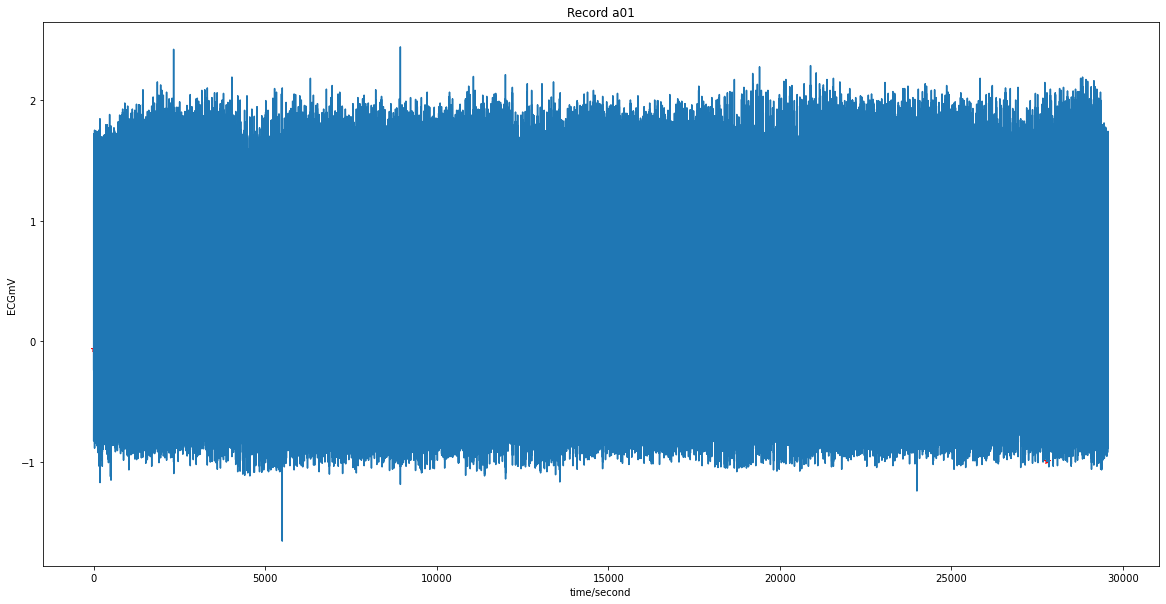

In [2]:
# docs: https://wfdb.readthedocs.io/en/latest/wfdb.html
# SpO2が含まれているデータは a01r のようにrが付いている
# records

# 'a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r'
subjects = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r']
records = {}

# データの読み込み
for subject in subjects:
    path = "dataset/" + subject
    records[subject] = wfdb.rdrecord(path)  # 計測データ
    records['ann_' + subject] = wfdb.rdann(path, 'apn', shift_samps=True) # ラベル

record = wfdb.rdrecord('dataset/a01')
annotation = wfdb.rdann('dataset/a01', 'apn', shift_samps=True)

wfdb.plot_wfdb(record=record, annotation=annotation, title='Record a01', time_units='seconds', figsize=(20,10)) 
#display(records['a01r'].__dict__)

In [3]:
# https://archive.physionet.org/physiobank/database/apnea-ecg/annotations.shtml
# display(annotation.__dict__)
display(len(records['ann_a01r'].sample))
display(len(records['ann_a01r'].symbol))

3108000 / 6000
print(records['ann_a01r'].symbol)

489

489

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',

In [4]:
# print(record.p_signal.size)  # 4つの信号×時間 = サイズ
# 4信号で割ってアノテーションの個数で割ると大体6000sampleになる
# https://www.physionet.org/lightwave/?db=apnea-ecg/1.0.0 でテストデータを確認できる
# a03rの場合、08:37:50以降はアノテーションの記録がない

print(records['a01r'].p_signal.size / 4 / 489)

6046.617586912065


In [5]:
# 特徴量の抽出、学習用のデータ作成
# 1 sample(6000個のデータ)毎に基本統計量を出してそれをInputに与える
# 例) record.p_signal[0:6000], record.p_signal[6001:12001]で統計量を出す
        
def extract_feature(data):
    return np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values, (data.max() - data.min()).values])

# train用
# 'b01r', 'c01r', 'c02r' はSpO2が0%のため除外、'c01r~c03rのデータはAのラベルが無い'
train_subjects = ['a01r', 'a02r', 'a04r', 'c03r']

# test用
test_subjects = ['a03r']

data_array = []
for subject in train_subjects:
    # annotation分だけ繰り返す
    ann_count = len(records['ann_'+subject].sample)
    data = pd.DataFrame(records[subject].p_signal, columns=records[subject].sig_name, dtype='float')
    print('---train_subjects---')
    data['SpO2'] = (data['SpO2'] / 100)
    print(data.head())
    data = data.fillna(method='ffill') # 直前の値を使って欠損値埋める
    print(data.isnull().sum())

    # 基本統計量を出す
    # data.describe()
    # ピークの差 (data.max() - data.min()).values
    # np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values])
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        data_array.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000

test_data = []
for subject in test_subjects:
    ann_count = len(records['ann_'+subject].sample)
    data = pd.DataFrame(records[subject].p_signal, columns=records[subject].sig_name, dtype='float')
    print('---test_subjects---')
    data['SpO2'] = (data['SpO2'] / 100)
    print(data.head())
    data = data.fillna(method='ffill') # 直前の値を使って欠損値埋める
    print(data.isnull().sum())
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        test_data.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000

---train_subjects---
   Resp C  Resp A   Resp N  SpO2
0 -0.1015 -0.3446  0.23545  0.98
1 -0.1025 -0.3455  0.23640  0.98
2 -0.1035 -0.3464  0.23735  0.98
3 -0.1045 -0.3473  0.23830  0.98
4 -0.1055 -0.3482  0.23925  0.98
Resp C    0
Resp A    0
Resp N    0
SpO2      0
dtype: int64
---train_subjects---
    Resp C   Resp A   Resp N  SpO2
0 -0.08525  0.22005 -0.41895  0.96
1 -0.08435  0.20915 -0.40935  0.96
2 -0.08345  0.19830 -0.39980  0.96
3 -0.08260  0.18740 -0.39030  0.96
4 -0.08170  0.17655 -0.38070  0.96
Resp C    0
Resp A    0
Resp N    0
SpO2      0
dtype: int64
---train_subjects---
    Resp C   Resp A   Resp N  SpO2
0 -0.14035 -0.14400  0.10895  0.93
1 -0.14060 -0.14650  0.11435  0.93
2 -0.14090 -0.14900  0.11980  0.93
3 -0.14120 -0.15155  0.12525  0.93
4 -0.14150 -0.15405  0.13070  0.93
Resp C    0
Resp A    0
Resp N    0
SpO2      0
dtype: int64
---train_subjects---
    Resp C   Resp A  Resp N  SpO2
0 -0.13890 -0.63440 -0.0644  0.97
1 -0.13850 -0.63560 -0.0648  0.97
2 -0.13815 -0

In [6]:
# 学習データ作成
print(len(data_array))
train_X = np.array(data_array)

print(train_X[0].size)
print(train_X[1])
type(train_X)

train_X.shape

# テストデータ作成
print(len(test_data))
test_X = np.array(test_data)
test_X.shape

1963
20
[-0.0564734  -0.04055112  0.02244431  0.97349892  0.05260965  0.15806497
  0.13869721  0.00678663  0.0891      0.52545     0.31735     0.98
 -0.1902     -0.40665    -0.28725     0.96        0.2793      0.9321
  0.6046      0.02      ]
519


(519, 20)

In [19]:
# NとAを1,0に変換する
from sklearn.preprocessing import LabelEncoder

label_data = []
for subject in train_subjects:
    le = LabelEncoder()
    le = le.fit(records['ann_' + subject].symbol)
    labels = le.transform(records['ann_' + subject].symbol)
    label_data = np.concatenate([label_data, labels], 0)

# テスト用のラベル
test_label = []
for subject in test_subjects:
    le = LabelEncoder()
    le = le.fit(records['ann_' + subject].symbol)
    test_label = le.transform(records['ann_' + subject].symbol)
    
display(label_data)
display(len(label_data))

display(test_label)
display(len(test_label))

array([1., 1., 1., ..., 0., 0., 0.])

1963

IndexError: arrays used as indices must be of integer (or boolean) type

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


# モデルの作成
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 1)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
from keras import optimizers
from keras.utils import plot_model

model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 12,402
Trainable params: 12,402
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(train_X, label_data,
                    batch_size=128,   # 64,128みたいに2の倍数がよく使われるらしい
                    epochs=200,
                    verbose=2)

Epoch 1/200


ValueError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


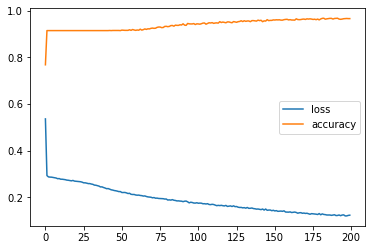

In [11]:
# plotしてみる
pd.DataFrame(history.history)[['loss', 'accuracy']].plot()

In [15]:
print("Evaluate on test data")
results = model.evaluate(test_X, test_label, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 519 samples")
predictions = model.predict(test_X[:519])
print("predictions shape:", predictions)

Evaluate on test data
5/5 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8574
test loss, test acc: [0.3514452278614044, 0.8574181199073792]
Generate predictions for 519 samples
predictions shape: [[9.60173309e-01]
 [8.26554477e-01]
 [9.85688567e-01]
 [9.84900236e-01]
 [9.88072932e-01]
 [8.58394742e-01]
 [7.72372007e-01]
 [1.73170775e-01]
 [9.00346518e-01]
 [9.39797640e-01]
 [1.53219759e-01]
 [9.91874993e-01]
 [3.11377048e-01]
 [9.77636993e-01]
 [6.73255801e-01]
 [9.67167616e-02]
 [1.05385959e-01]
 [5.42750955e-03]
 [2.78651714e-03]
 [2.15320587e-02]
 [9.08869505e-03]
 [9.15765762e-04]
 [1.12527609e-03]
 [6.96551800e-03]
 [9.16957855e-04]
 [3.01516056e-03]
 [1.35773420e-03]
 [1.79681182e-03]
 [9.94920731e-04]
 [1.96826458e-03]
 [1.36300921e-03]
 [6.84797764e-04]
 [2.30193138e-04]
 [1.35076046e-03]
 [1.15638971e-03]
 [8.04603100e-04]
 [3.69697809e-04]
 [9.94333022e-05]
 [2.12579966e-04]
 [1.12509915e-04]
 [1.32650137e-04]
 [3.05503607e-04]
 [2.96831131e-04]
 

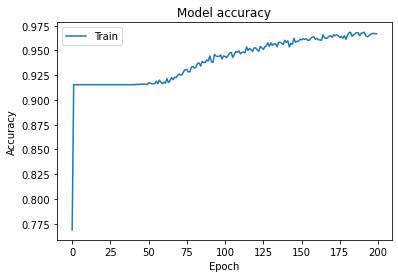

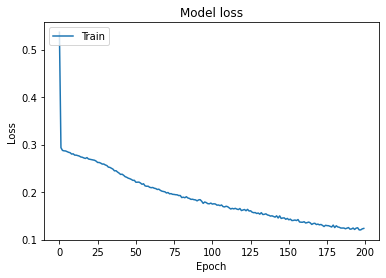

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()